### GTSRB Traffic Sign Recognition - Part III

### CODE ONLY, For a detailed report, please refer to the GTSRB Final Report Part III

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary modules
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing

Using TensorFlow backend.


### Preprocessing

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)

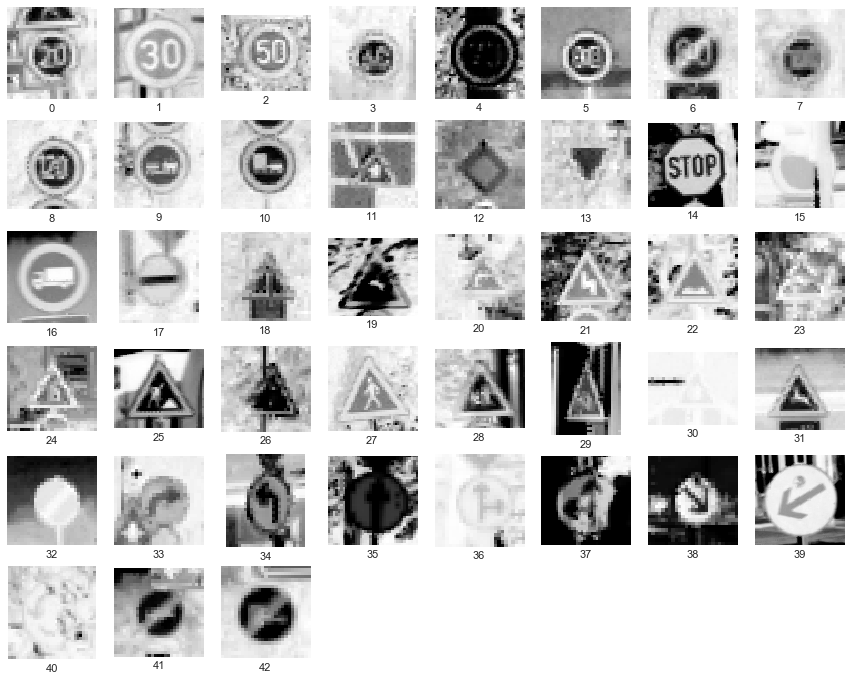

In [4]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

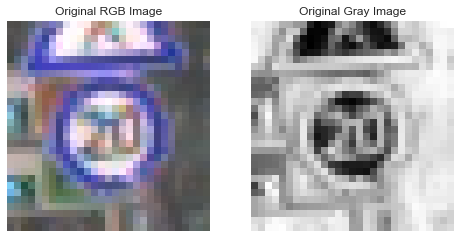

In [5]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

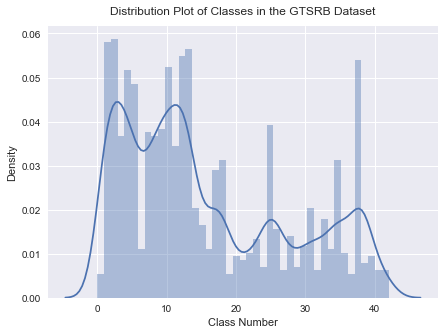

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

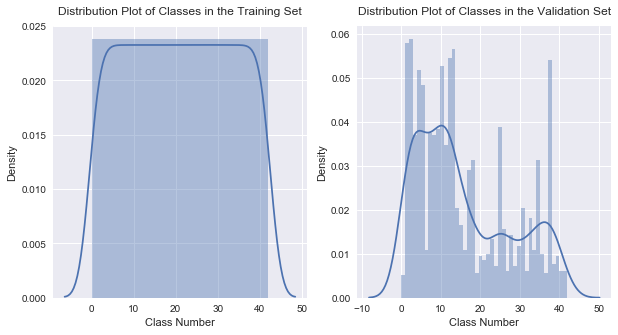

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [7]:
# resizing
resize_data = GTSRB_sungil.resize_all(gray_GTSRB, size = (28, 28))

# normalizing data, RGB/grayscale images are out of 255
norm_resized = resize_data / 255.0

# reshaping to be suitable for keras and tensorflow
nn_reshaped = GTSRB_sungil.nn_reshape(norm_resized)

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
x_train, x_val, y_class, y_val = train_test_split(nn_reshaped, data_class,\
                                                  stratify = data_class, test_size = 0.055)

# random under-sampling
und_train, und_class = GTSRB_sungil.under_sample(x_train, y_class)

# converting a class vector to binary class matrix
y_class_bin = keras.utils.to_categorical(und_class, num_classes)
y_val_bin = keras.utils.to_categorical(y_val, num_classes)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_train) + len(x_val)
print('Total of %i images in the training data' % len(und_train))
print('Total of %i images in the validation data' % len(x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_train)/tot_len*100, len(x_val)/tot_len*100))

### Exploring with ConvNet Architectures

#### Small (Conv-Pool-Dropout)

In [8]:
model1 = keras.Sequential([\
    keras.layers.Conv2D(32, (4, 4), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (3, 3)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history1 = model1.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 11s 1ms/step - loss: 0.0932 - acc: 0.9773 - val_loss: 0.0713 - val_acc: 0.9793
Epoch 2/20
8514/8514 [==============================] - 12s 1ms/step - loss: 0.0518 - acc: 0.9838 - val_loss: 0.0462 - val_acc: 0.9851
Epoch 3/20
8514/8514 [==============================] - 9s 1ms/step - loss: 0.0337 - acc: 0.9890 - val_loss: 0.0341 - val_acc: 0.9886 - loss: 0.0354 - acc: 0.9
Epoch 4/20
8514/8514 [==============================] - 12s 1ms/step - loss: 0.0254 - acc: 0.9915 - val_loss: 0.0275 - val_acc: 0.9906
Epoch 5/20
8514/8514 [==============================] - 12s 1ms/step - loss: 0.0201 - acc: 0.9932 - val_loss: 0.0231 - val_acc: 0.9921
Epoch 6/20
8514/8514 [==============================] - 11s 1ms/step - loss: 0.0166 - acc: 0.9944 - val_loss: 0.0203 - val_acc: 0.9929
Epoch 7/20
8514/8514 [==============================] - 10s 1ms/step - loss: 0.0141 - acc: 0.9952 - val_loss: 0.0182 

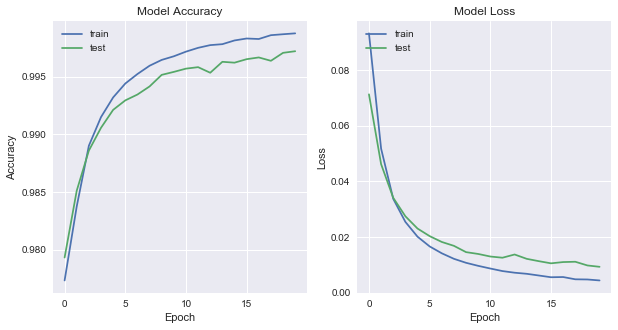

In [9]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['acc']), plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss']), plt.plot(history1.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [10]:
model2 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (3, 3)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history2 = model2.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 20s 2ms/step - loss: 0.0883 - acc: 0.9779 - val_loss: 0.0646 - val_acc: 0.9808
Epoch 2/20
8514/8514 [==============================] - 16s 2ms/step - loss: 0.0458 - acc: 0.9855 - val_loss: 0.0424 - val_acc: 0.9864
Epoch 3/20
8514/8514 [==============================] - 17s 2ms/step - loss: 0.0296 - acc: 0.9902 - val_loss: 0.0309 - val_acc: 0.9896
Epoch 4/20
8514/8514 [==============================] - 20s 2ms/step - loss: 0.0219 - acc: 0.9925 - val_loss: 0.0259 - val_acc: 0.9910
Epoch 5/20
8514/8514 [==============================] - 20s 2ms/step - loss: 0.0171 - acc: 0.9943 - val_loss: 0.0216 - val_acc: 0.9923
Epoch 6/20
8514/8514 [==============================] - 16s 2ms/step - loss: 0.0138 - acc: 0.9954 - val_loss: 0.0193 - val_acc: 0.9929
Epoch 7/20
8514/8514 [==============================] - 16s 2ms/step - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0172 - val_acc: 0.9939
Epoch 8

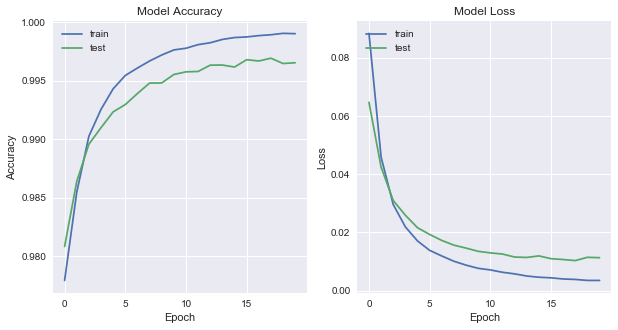

In [11]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['acc']), plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss']), plt.plot(history2.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Dropout)

In [12]:
model3 = keras.Sequential([\
    keras.layers.Conv2D(32, (4, 4), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (2, 2), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (3, 3)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history3 = model3.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 36s 4ms/step - loss: 0.0757 - acc: 0.9805 - val_loss: 0.0418 - val_acc: 0.9864
Epoch 2/20
8514/8514 [==============================] - 26s 3ms/step - loss: 0.0278 - acc: 0.9907 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 3/20
8514/8514 [==============================] - 31s 4ms/step - loss: 0.0160 - acc: 0.9946 - val_loss: 0.0187 - val_acc: 0.9936
Epoch 4/20
8514/8514 [==============================] - 32s 4ms/step - loss: 0.0115 - acc: 0.9962 - val_loss: 0.0141 - val_acc: 0.9951
Epoch 5/20
8514/8514 [==============================] - 27s 3ms/step - loss: 0.0086 - acc: 0.9971 - val_loss: 0.0118 - val_acc: 0.9960
Epoch 6/20
8514/8514 [==============================] - 34s 4ms/step - loss: 0.0065 - acc: 0.9979 - val_loss: 0.0097 - val_acc: 0.9968
Epoch 7/20
8514/8514 [==============================] - 24s 3ms/step - loss: 0.0056 - acc: 0.9981 - val_loss: 0.0098 - val_acc: 0.9969
Epoch 8

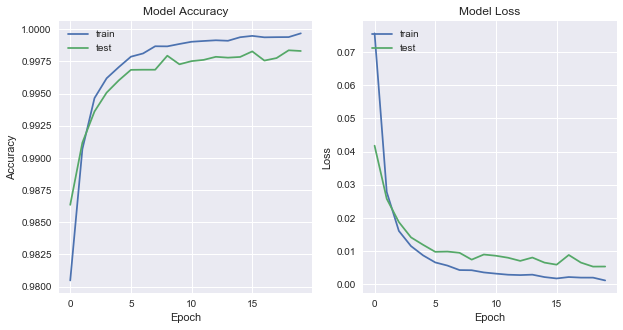

In [13]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['acc']), plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss']), plt.plot(history3.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [14]:
model4 = keras.Sequential([\
    keras.layers.Conv2D(64, (4, 4), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history4 = model4.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 72s 8ms/step - loss: 0.0669 - acc: 0.9823 - val_loss: 0.0325 - val_acc: 0.9887
Epoch 2/20
8514/8514 [==============================] - 71s 8ms/step - loss: 0.0207 - acc: 0.9930 - val_loss: 0.0192 - val_acc: 0.9934
Epoch 3/20
8514/8514 [==============================] - 70s 8ms/step - loss: 0.0118 - acc: 0.9960 - val_loss: 0.0164 - val_acc: 0.9947
Epoch 4/20
8514/8514 [==============================] - 71s 8ms/step - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0139 - val_acc: 0.9958
Epoch 5/20
8514/8514 [==============================] - 79s 9ms/step - loss: 0.0063 - acc: 0.9980 - val_loss: 0.0109 - val_acc: 0.9966
Epoch 6/20
8514/8514 [==============================] - 73s 9ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0091 - val_acc: 0.9972
Epoch 7/20
8514/8514 [==============================] - 72s 8ms/step - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0085 - val_acc: 0.9974
Epoch 8

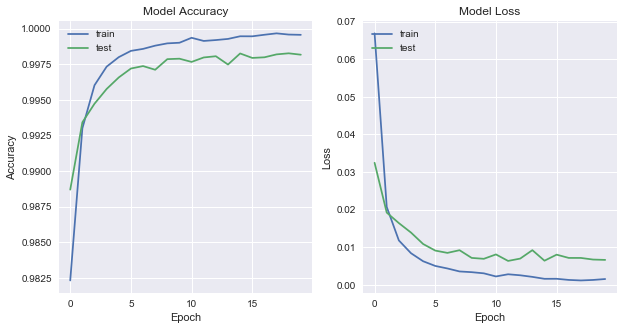

In [15]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['acc']), plt.plot(history4.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss']), plt.plot(history4.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [16]:
model5 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (3, 3)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history5 = model5.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 42s 5ms/step - loss: 0.0746 - acc: 0.9807 - val_loss: 0.0408 - val_acc: 0.9866
Epoch 2/20
8514/8514 [==============================] - 50s 6ms/step - loss: 0.0245 - acc: 0.9916 - val_loss: 0.0206 - val_acc: 0.9929
Epoch 3/20
8514/8514 [==============================] - 43s 5ms/step - loss: 0.0144 - acc: 0.9951 - val_loss: 0.0171 - val_acc: 0.9939
Epoch 4/20
8514/8514 [==============================] - 48s 6ms/step - loss: 0.0097 - acc: 0.9967 - val_loss: 0.0121 - val_acc: 0.9959
Epoch 5/20
8514/8514 [==============================] - 45s 5ms/step - loss: 0.0074 - acc: 0.9976 - val_loss: 0.0103 - val_acc: 0.9965
Epoch 6/20
8514/8514 [==============================] - 48s 6ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 7/20
8514/8514 [==============================] - 48s 6ms/step - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0093 - val_acc: 0.9969
Epoch 8

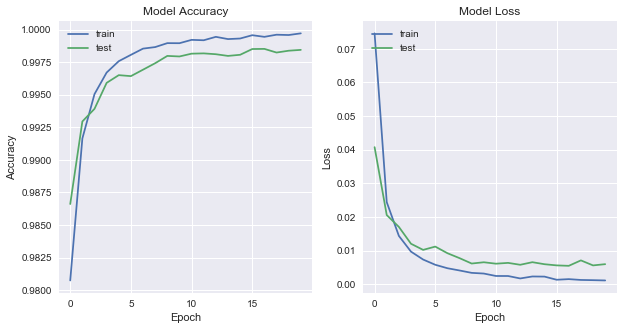

In [17]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['acc']), plt.plot(history5.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss']), plt.plot(history5.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Pool-Dropout)

In [18]:
model6 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model6.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history6 = model6.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 16s 2ms/step - loss: 0.0901 - acc: 0.9780 - val_loss: 0.0592 - val_acc: 0.9820
Epoch 2/20
8514/8514 [==============================] - 20s 2ms/step - loss: 0.0417 - acc: 0.9865 - val_loss: 0.0356 - val_acc: 0.9878
Epoch 3/20
8514/8514 [==============================] - 20s 2ms/step - loss: 0.0265 - acc: 0.9909 - val_loss: 0.0253 - val_acc: 0.9911
Epoch 4/20
8514/8514 [==============================] - 15s 2ms/step - loss: 0.0194 - acc: 0.9933 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 5/20
8514/8514 [==============================] - 18s 2ms/step - loss: 0.0151 - acc: 0.9947 - val_loss: 0.0155 - val_acc: 0.9948
Epoch 6/20
8514/8514 [==============================] - 22s 3ms/step - loss: 0.0125 - acc: 0.9958 - val_loss: 0.0158 - val_acc: 0.9944
Epoch 7/20
8514/8514 [==============================] - 17s 2ms/step - loss: 0.0104 - acc: 0.9964 - val_loss: 0.0126 - val_acc: 0.9959
Epoch 8

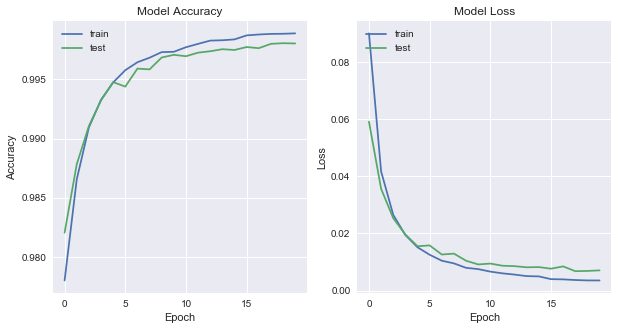

In [19]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['acc']), plt.plot(history6.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss']), plt.plot(history6.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [20]:
model7 = keras.Sequential([\
    keras.layers.Conv2D(32, (4, 4), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (2, 2), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model7.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history7 = model7.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 18s 2ms/step - loss: 0.0943 - acc: 0.9776 - val_loss: 0.0640 - val_acc: 0.9811
Epoch 2/20
8514/8514 [==============================] - 12s 1ms/step - loss: 0.0448 - acc: 0.9855 - val_loss: 0.0355 - val_acc: 0.9880
Epoch 3/20
8514/8514 [==============================] - 14s 2ms/step - loss: 0.0286 - acc: 0.9904 - val_loss: 0.0266 - val_acc: 0.9906
Epoch 4/20
8514/8514 [==============================] - 19s 2ms/step - loss: 0.0212 - acc: 0.9928 - val_loss: 0.0211 - val_acc: 0.9927
Epoch 5/20
8514/8514 [==============================] - 19s 2ms/step - loss: 0.0171 - acc: 0.9941 - val_loss: 0.0168 - val_acc: 0.9944
Epoch 6/20
8514/8514 [==============================] - 14s 2ms/step - loss: 0.0144 - acc: 0.9949 - val_loss: 0.0153 - val_acc: 0.9949
Epoch 7/20
8514/8514 [==============================] - 14s 2ms/step - loss: 0.0116 - acc: 0.9961 - val_loss: 0.0138 - val_acc: 0.9957
Epoch 8

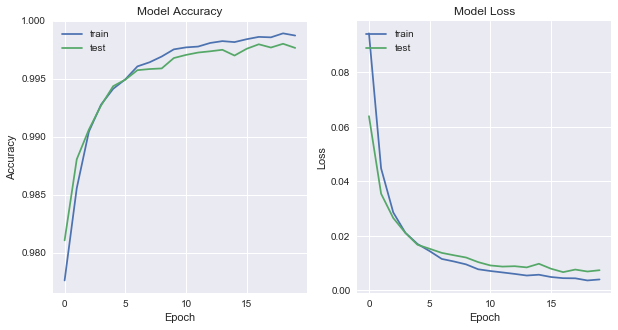

In [21]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['acc']), plt.plot(history7.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss']), plt.plot(history7.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Final CNN model

In [32]:
model_fin = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (3, 3)),\
    keras.layers.Dropout(0.25),\
    keras.layers.Flatten(),\
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model_fin.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history_fin = model_fin.fit(und_train, y_class_bin, epochs = 16, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/16
8514/8514 [==============================] - 43s 5ms/step - loss: 0.0774 - acc: 0.9804 - val_loss: 0.0441 - val_acc: 0.9856
Epoch 2/16
8514/8514 [==============================] - 41s 5ms/step - loss: 0.0266 - acc: 0.9911 - val_loss: 0.0240 - val_acc: 0.9917
Epoch 3/16
8514/8514 [==============================] - 46s 5ms/step - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0201 - val_acc: 0.9932
Epoch 4/16
8514/8514 [==============================] - 37s 4ms/step - loss: 0.0110 - acc: 0.9962 - val_loss: 0.0126 - val_acc: 0.9960
Epoch 5/16
8514/8514 [==============================] - 48s 6ms/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0120 - val_acc: 0.9962
Epoch 6/16
8514/8514 [==============================] - 46s 5ms/step - loss: 0.0069 - acc: 0.9977 - val_loss: 0.0119 - val_acc: 0.9960
Epoch 7/16
8514/8514 [==============================] - 41s 5ms/step - loss: 0.0064 - acc: 0.9980 - val_loss: 0.0106 - val_acc: 0.9965
Epoch 8

CNN classification report: 

               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.97      0.93      0.95       122
           2       0.91      0.92      0.92       124
           3       0.95      0.91      0.93        78
           4       0.90      0.98      0.94       109
           5       0.92      0.84      0.88       102
           6       1.00      1.00      1.00        23
           7       0.95      0.95      0.95        79
           8       0.95      0.95      0.95        78
           9       1.00      1.00      1.00        81
          10       1.00      0.98      0.99       111
          11       1.00      0.95      0.97        73
          12       0.97      0.97      0.97       115
          13       0.99      1.00      1.00       119
          14       1.00      1.00      1.00        43
          15       0.88      1.00      0.93        35
          16       1.00      1.00      1.00        

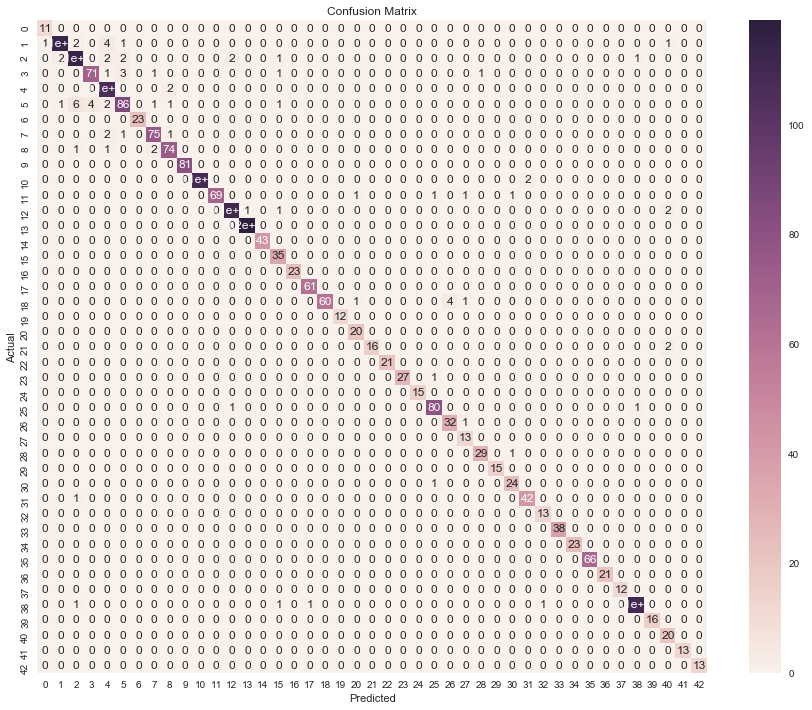

In [34]:
# classification report
y_prob = model_fin.predict(x_val)
cls_pred = y_prob.argmax(axis = -1)
print("CNN classification report:", "\n\n", classification_report(y_val, cls_pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_val, cls_pred, average = 'weighted')

# accuracy confusion matrix
cm = confusion_matrix(y_val, cls_pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

In [35]:
print('The validation precision score is', precision, '\nThe validation recall score is', recall,\
      '\nThe validation f-score is', fbeta_score)

The validation precision score is 0.9638767637940292 
The validation recall score is 0.9624478442280946 
The validation f-score is 0.9624967228879753


### Final 3 Models

| Classifiers | Precision | Recall | F-Score |
| --- | --- | --- | --- |
| CNN with the Architecture of Conv-Conv-Pool-Dropout (model1) | 0.963877 | 0.962448 | 0.962497 |
| Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier from Part II | 0.924908 | 0.918869 | 0.918973 |
| Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier from Part II | 0.923204 | 0.919796 | 0.920249 |
